In [1]:
import os
os.environ['THEANO_FLAGS'] = "device=gpu"  

In [2]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
import math, json, os, sys

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
import keras.backend as K


TRAIN_DIR = ''
VALID_DIR = ''


SIZE = (224, 224)
BATCH_SIZE = 32


if __name__ == "__main__":
    num_train_samples = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)]) #train data 수집
    num_valid_samples = sum([len(files) for r, d, files in os.walk(VALID_DIR)]) #validation data 수집

    num_train_steps = math.floor(num_train_samples/BATCH_SIZE) 
    num_valid_steps = math.floor(num_valid_samples/BATCH_SIZE)

    gen = keras.preprocessing.image.ImageDataGenerator() # Train을 위한 DataGenerator 사용
    val_gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True)  # validation을 위한 DataGenerator 사용

    batches = gen.flow_from_directory(TRAIN_DIR, target_size=SIZE, class_mode='categorical', shuffle=True, batch_size=BATCH_SIZE)
    val_batches = val_gen.flow_from_directory(VALID_DIR, target_size=SIZE, class_mode='categorical', shuffle=True, batch_size=BATCH_SIZE)

    model = keras.applications.resnet50.ResNet50() #디
    

    
    classes = list(iter(batches.class_indices))
    model.layers.pop()
    
    for layer in model.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
            layer.trainable = True
            K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
            K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False
            
    last = model.layers[-1].output
    x = Dense(len(classes), activation="softmax")(last)
    finetuned_model = Model(model.input, x)
    finetuned_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    for c in batches.class_indices:
        classes[batches.class_indices[c]] = c
    finetuned_model.classes = classes
    
    fileName="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    checkpointer = ModelCheckpoint(fileName, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    history = finetuned_model.fit_generator(batches, steps_per_epoch=num_train_steps, epochs=1000, callbacks=[early_stopping, checkpointer], validation_data=val_batches, validation_steps=num_valid_steps)
    finetuned_model.save('resnet50_camera.h5')


Using TensorFlow backend.


Found 63313 images belonging to 4 classes.
Found 27112 images belonging to 4 classes.
Epoch 1/1000
1978/1978 [==============================] - 817s 413ms/step - loss: 0.4524 - acc: 0.8375 - val_loss: 0.4673 - val_acc: 0.8425

Epoch 00001: val_loss improved from inf to 0.46732, saving model to weights-improvement-01-0.84.hdf5
Epoch 2/1000
1978/1978 [==============================] - 595s 301ms/step - loss: 0.2025 - acc: 0.9320 - val_loss: 0.4509 - val_acc: 0.8551

Epoch 00002: val_loss improved from 0.46732 to 0.45086, saving model to weights-improvement-02-0.86.hdf5
Epoch 3/1000
1978/1978 [==============================] - 595s 301ms/step - loss: 0.1502 - acc: 0.9490 - val_loss: 0.4612 - val_acc: 0.8571

Epoch 00003: val_loss did not improve from 0.45086
Epoch 4/1000
1978/1978 [==============================] - 596s 301ms/step - loss: 0.1197 - acc: 0.9575 - val_loss: 0.4900 - val_acc: 0.8566

Epoch 00004: val_loss did not improve from 0.45086
Epoch 5/1000
1978/1978 [==================

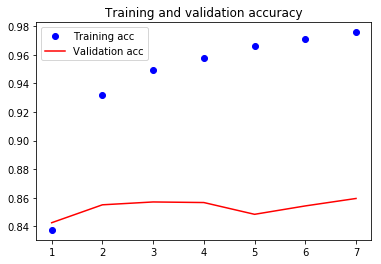

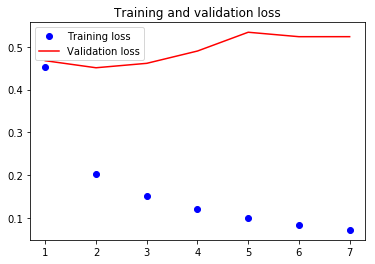

In [4]:
import matplotlib.pylab as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model
import time
start = time.time() 
caltech_dir = ""
image_w = 224
image_h = 224

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('resnet50_camera.h5')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt0 = 0
cnt1 = 0
cnt2 = 0
cnt3 = 0 
cnt4 = 0
cnt5 = 0
cnt6 = 0

for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    if pre_ans == 0: 
        cnt0 +=1
    elif pre_ans == 1: 
        cnt1 +=1
    elif pre_ans == 2: 
        cnt2 +=1
    elif pre_ans == 3: 
        cnt3 +=1
    cnt4 += 1

print("%d개, %d개, %d개, %d개 예측하였습니다"%(cnt4,cnt0,cnt1,cnt2,cnt3))
print("time :", time.time() - start)